In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import zipfile
from torch.utils.data import Dataset, DataLoader

import string

In [4]:
# Import your models
from mnist_skeptic_v9 import skeptic_v9
#from mnist_skeptic_v8 import skeptic_v8
#from mnist_skeptic_v7 import skeptic_v7

class ModelEnsemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, x):
        predictions = [model(x) for model in self.models]
        return torch.stack(predictions).mean(dim=0)
    
    def eval(self):
        for model in self.models:
            model.eval()

In [6]:
def predict_ensemble(ensemble, data_loader):
    ensemble.eval()
    all_predictions = []
    all_labels = []
    device = next(ensemble.models[0].parameters()).device  # Get the device of the first model
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            predictions = ensemble.predict(images)
            all_predictions.append(predictions.argmax(dim=1).cpu())
            all_labels.append(labels)
    
    return torch.cat(all_predictions), torch.cat(all_labels)

# Create model instances
#skeptic_v7 = skeptic_v7()
#skeptic_v8 = skeptic_v8()
#skeptic_v9 = skeptic_v9()
#skeptic_v10_family = skeptic_v9()

# Load pre-trained weights
#skeptic_v7.load_state_dict(torch.load('saved_models/skeptic_v7_finetuned_all_participants.pth'))
#skeptic_v8.load_state_dict(torch.load('saved_models/skeptic_v8_finetuned_all_participants.pth'))
#skeptic_v9.load_state_dict(torch.load('saved_models/skeptic_v9_finetuned_all_participants.pth'))

# Create a list to store all model instances
skeptic_v10_family = []

# Loop through letters 'a' to 't'
for letter in string.ascii_lowercase[:20]:  # This gives 'a' to 't'
    model = skeptic_v9()  # Create a new instance of the model
    model.load_state_dict(torch.load(f'saved_models/skeptic_v10/skeptic_v10_{letter}_finetuned.pth'))
    skeptic_v10_family.append(model)

# Create ensemble with all 20 models
ensemble = ModelEnsemble(skeptic_v10_family)

# Create ensemble
#ensemble = ModelEnsemble([skeptic_v7, skeptic_v8, skeptic_v9])

C:\Users\Sai\AppData\Local\Temp\ipykernel_3172\1141896434.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'saved_models/skeptic_v10/sk

In [6]:
import os
import zipfile
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    print(f"Total training images: {len(train_images)}")
    print(f"Total test images: {len(test_images)}")
    
    for participant, data in participant_data.items():
        print(f"Participant {participant}:")
        print(f"  Training images: {len(data['train'][0])}")
        print(f"  Test images: {len(data['test'][0])}")

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Load the data
test_digits_folder = 'test_digits'
train_images, train_labels, test_images, test_labels, participant_data = load_all_experimental_data(test_digits_folder)

# Create datasets
train_dataset = ExperimentalDataset(train_images, train_labels)
test_dataset = ExperimentalDataset(test_images, test_labels)

# Create dataloaders if needed
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images: 10
Participant 69:
  Training images: 5000
  Test images: 10
Participant 74:
  Training images: 1000
  Test images: 10
Participant 80:
  Training images: 5000
  Test images: 10
Participant 94:
  Training images: 1000
  Test images: 10
Participant 98:
  Training images: 1000
  Test images: 10


In [7]:
#ensemble predictions
ensemble_predictions, true_labels = predict_ensemble(ensemble, test_loader)

In [8]:
# Calculate accuracy
accuracy = (ensemble_predictions == true_labels).float().mean()
print(f"Ensemble Accuracy: {accuracy.item():.4f}")

Ensemble Accuracy: 0.9071


In [7]:
#individual model predictions
def predict_individual(model, data_loader):
    model.eval()
    all_predictions = []
    device = next(model.parameters()).device  # Get the device of the model
    
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            predictions = model(images)
            all_predictions.append(predictions.argmax(dim=1).cpu())
    
    return torch.cat(all_predictions)

# Now use it like this:
''''individual_predictions = {
    'skeptic_v7': predict_individual(skeptic_v7, test_loader),
    'skeptic_v8': predict_individual(skeptic_v8, test_loader),
    'skeptic_v9': predict_individual(skeptic_v9, test_loader)
}'''

individual_predictions = {skeptic_v10_family[i]: predict_individual(skeptic_v10_family[i], test_loader) for i in range(20)}

In [8]:
import math

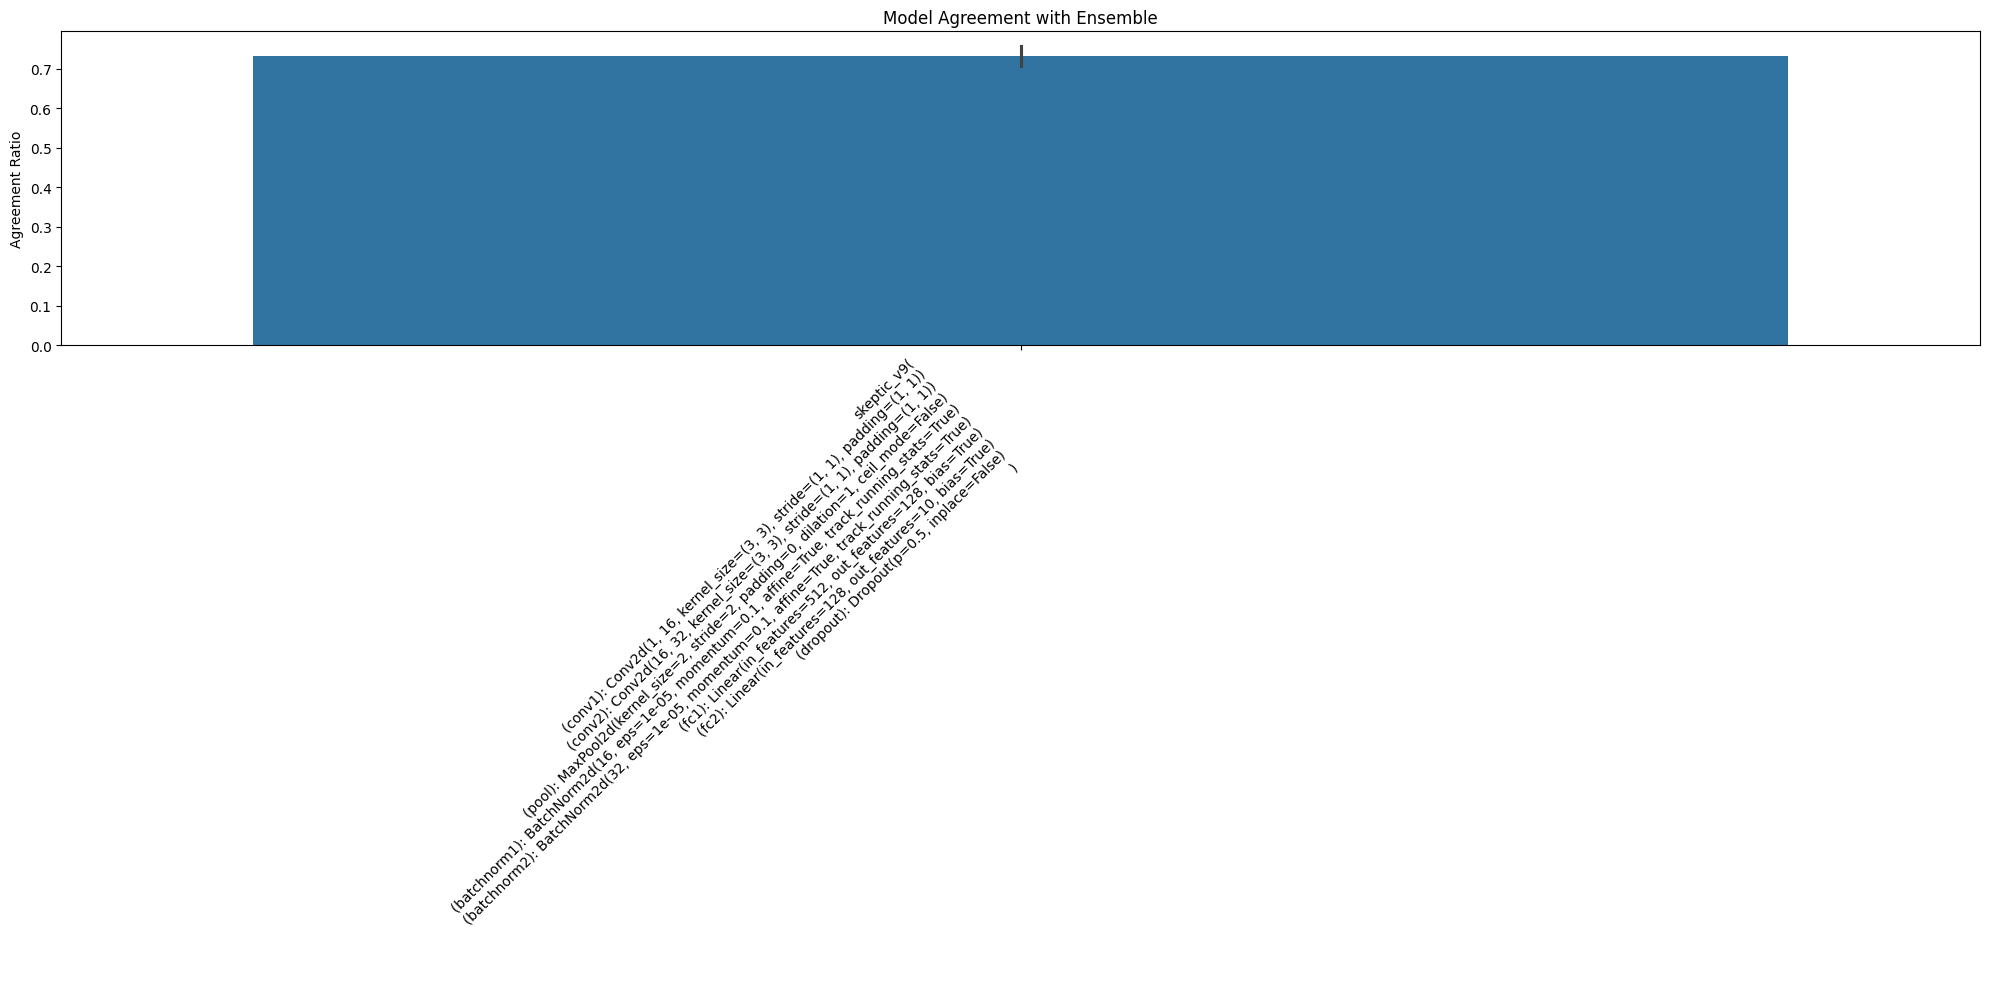

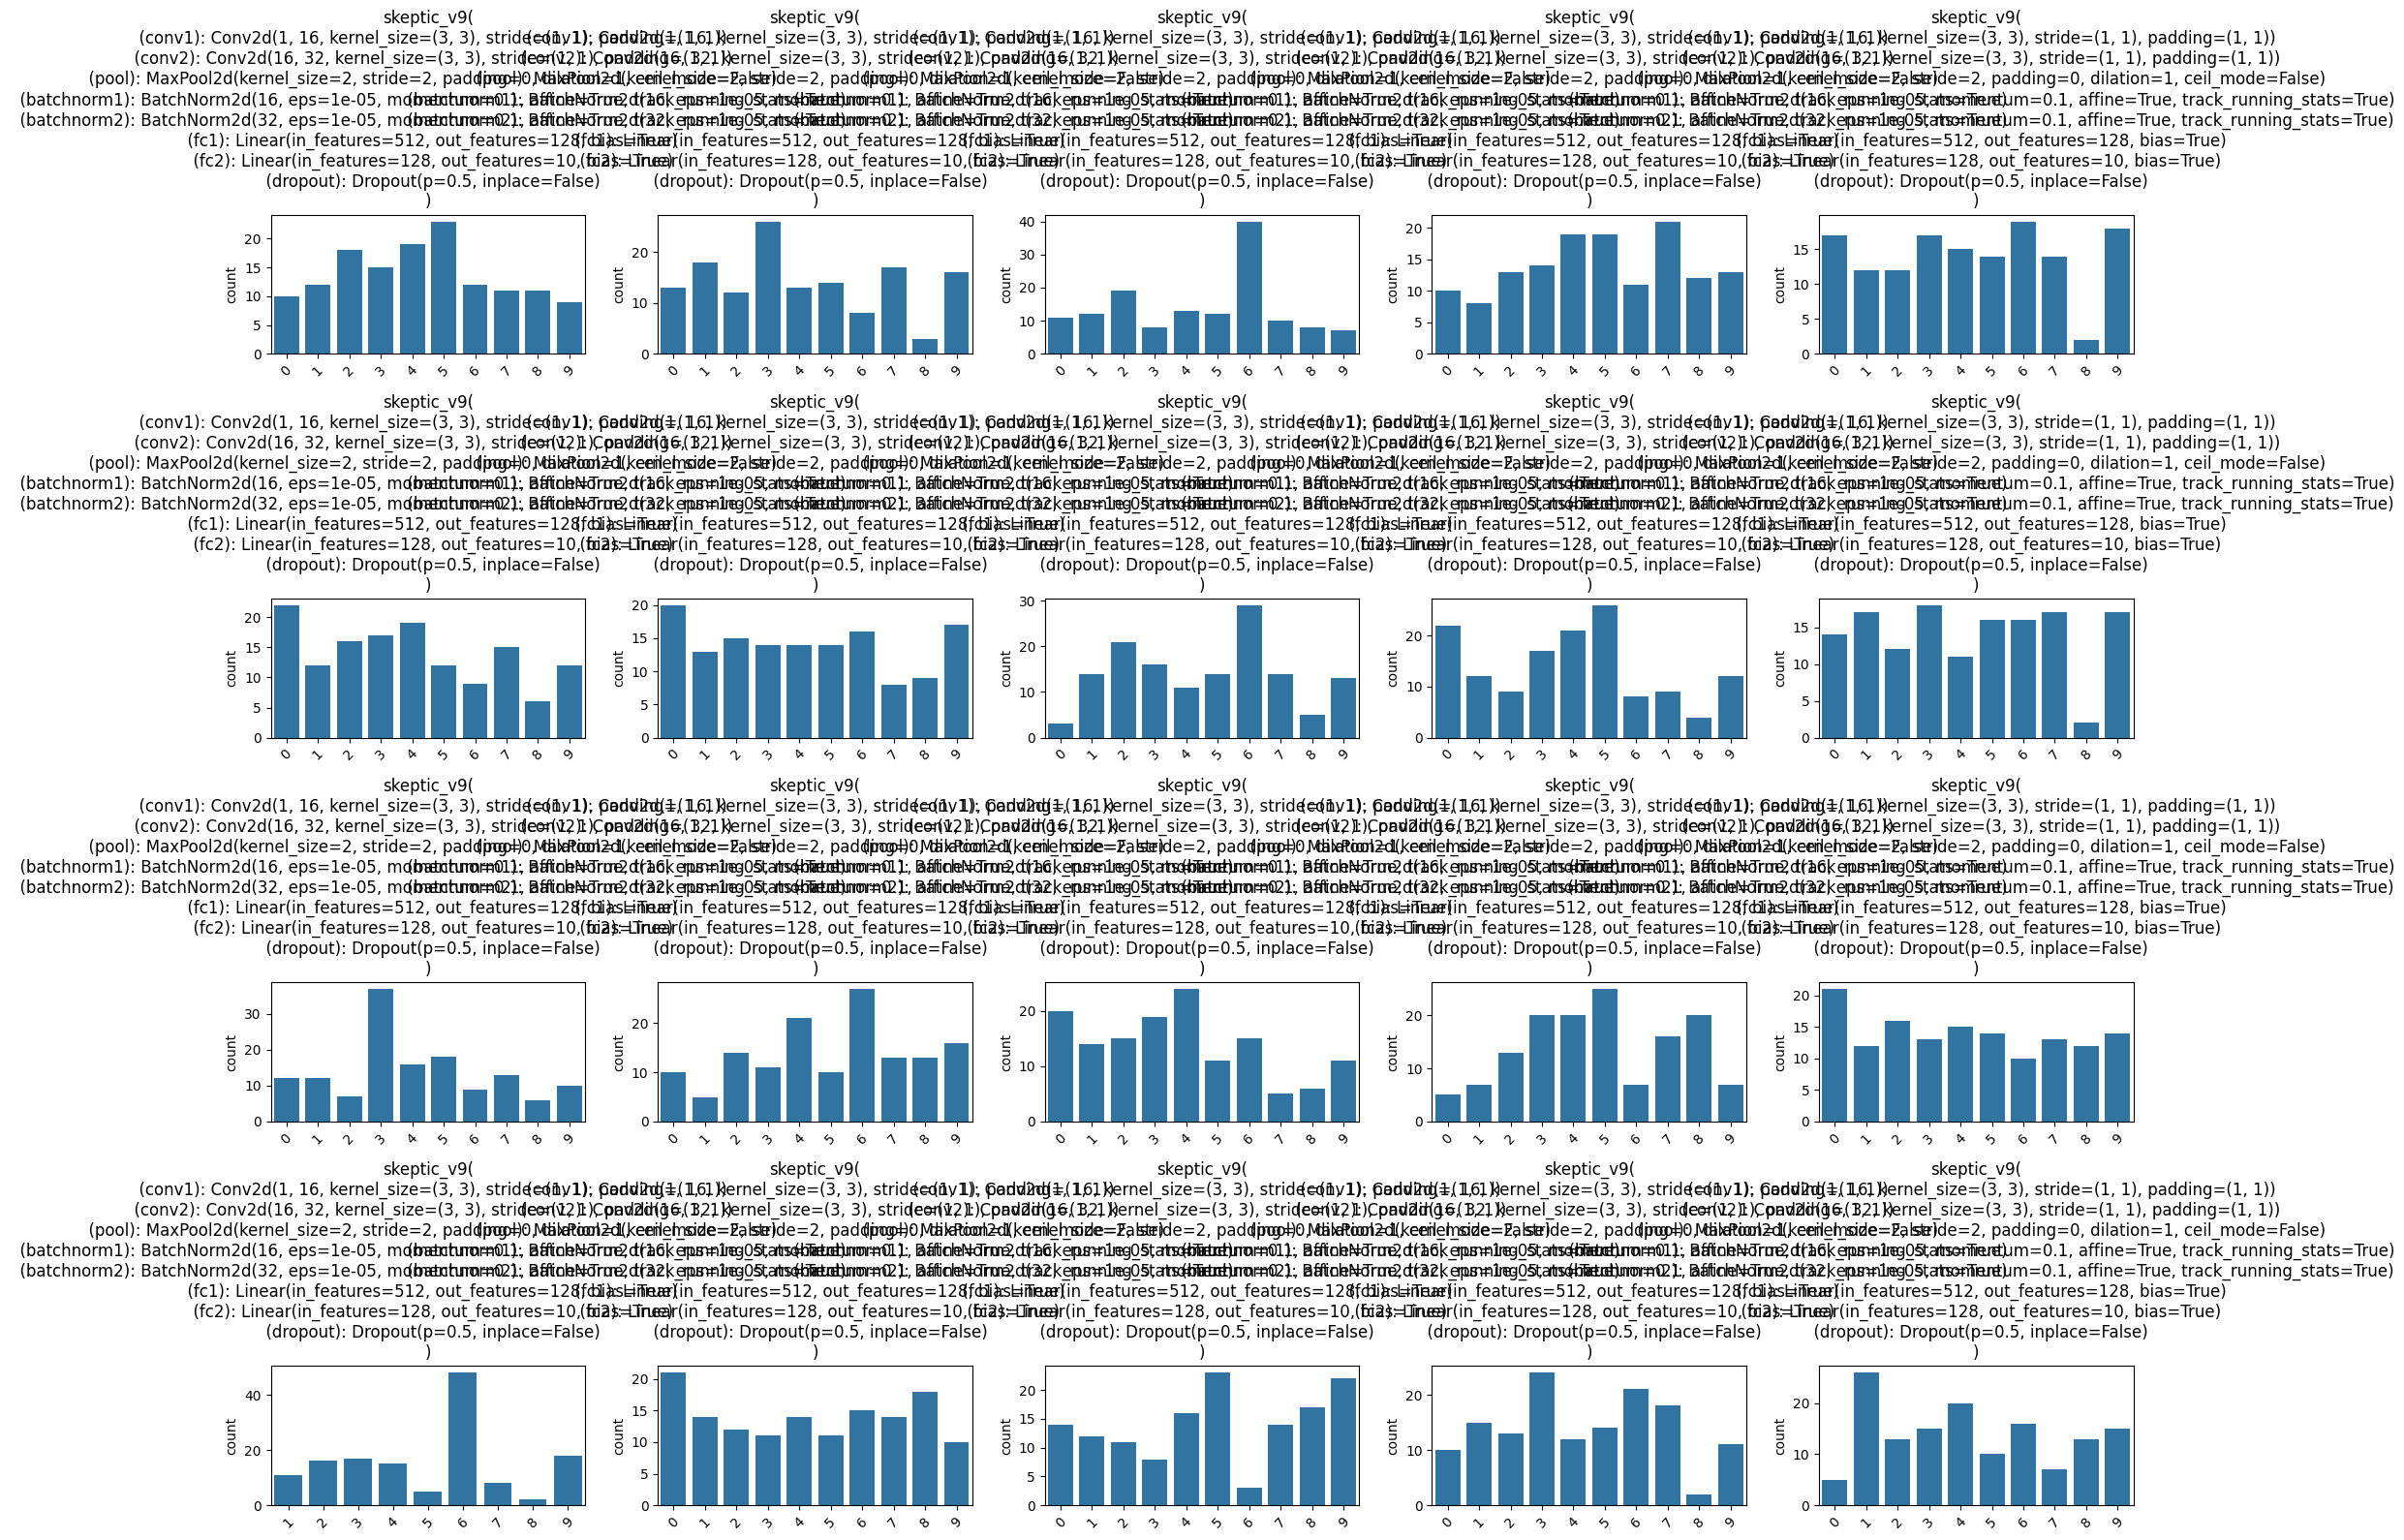

In [9]:
def analyze_predictions(ensemble_pred, individual_preds):
    # Calculate agreement
    agreement = (ensemble_pred.unsqueeze(1) == torch.stack(list(individual_preds.values())).T).float().mean(dim=0)
    
    # Plot model agreement
    plt.figure(figsize=(20, 10))
    sns.barplot(x=list(individual_preds.keys()), y=agreement)
    plt.title('Model Agreement with Ensemble')
    plt.ylabel('Agreement Ratio')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Prediction distribution
    num_models = len(individual_preds)
    num_cols = 5  # You can adjust this
    num_rows = math.ceil(num_models / num_cols)
    
    plt.figure(figsize=(4*num_cols, 4*num_rows))
    for i, (name, preds) in enumerate(individual_preds.items()):
        plt.subplot(num_rows, num_cols, i+1)
        sns.countplot(x=preds.numpy())
        plt.title(f'{name}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage
analyze_predictions(ensemble_predictions, individual_predictions)

In [10]:
#overfitting analysis
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    device = next(model.parameters()).device

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def analyze_overfitting(models, train_loader, test_loader):
    results = []
    for name, model in models.items():
        train_acc = evaluate_model(model, train_loader)
        test_acc = evaluate_model(model, test_loader)
        results.append({
            'Model': name,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc,
            'Overfitting': train_acc - test_acc
        })
    
    df = pd.DataFrame(results)
    df = df.sort_values('Overfitting', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Overfitting', data=df)
    plt.title('Overfitting Analysis')
    plt.show()
    
    return df

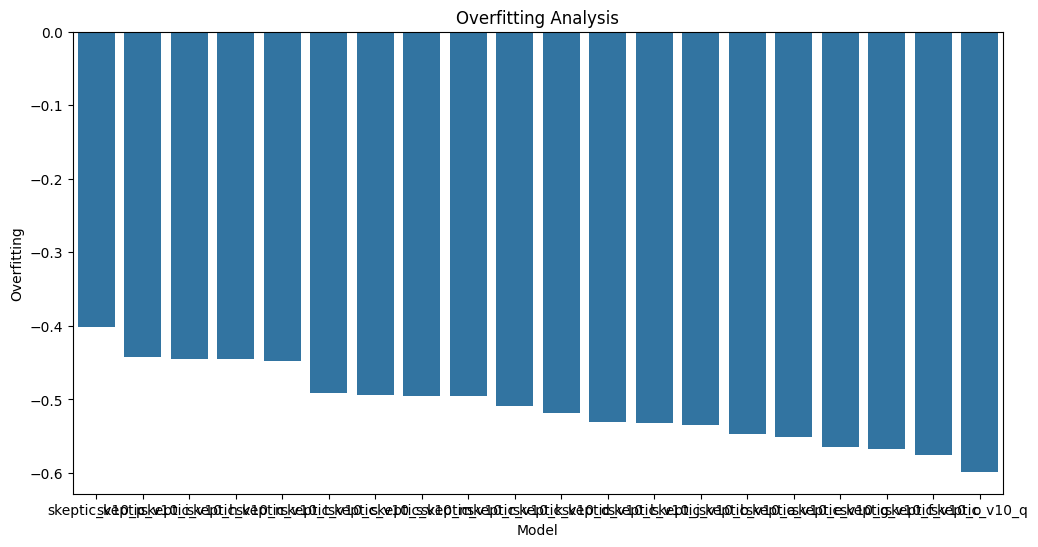

            Model  Train Accuracy  Test Accuracy  Overfitting
15  skeptic_v10_p        0.191129       0.592857    -0.401728
8   skeptic_v10_i        0.185710       0.628571    -0.442862
7   skeptic_v10_h        0.225581       0.671429    -0.445848
13  skeptic_v10_n        0.189839       0.635714    -0.445876
19  skeptic_v10_t        0.201484       0.650000    -0.448516
2   skeptic_v10_c        0.179516       0.671429    -0.491912
18  skeptic_v10_s        0.191097       0.685714    -0.494618
12  skeptic_v10_m        0.183484       0.678571    -0.495088
17  skeptic_v10_r        0.225710       0.721429    -0.495719
10  skeptic_v10_k        0.190484       0.700000    -0.509516
3   skeptic_v10_d        0.230871       0.750000    -0.519129
11  skeptic_v10_l        0.197968       0.728571    -0.530604
9   skeptic_v10_j        0.203677       0.735714    -0.532037
1   skeptic_v10_b        0.215323       0.750000    -0.534677
0   skeptic_v10_a        0.217774       0.764286    -0.546512
4   skep

In [11]:
# Assuming you have train_loader and test_loader
#overfitting_results = analyze_overfitting({'skeptic_v7': skeptic_v7, 'skeptic_v8': skeptic_v8, 'skeptic_v9': skeptic_v9},train_loader, test_loader)
overfitting_results = analyze_overfitting({f'skeptic_v10_{letter}': model for letter, model in zip(string.ascii_lowercase[:20], skeptic_v10_family)}, train_loader, test_loader)
print(overfitting_results)

In [12]:
#model ranking and selection
def rank_models(overfitting_df, test_accuracy_weight=0.7, overfitting_weight=0.3):
    df = overfitting_df.copy()
    df['Score'] = (df['Test Accuracy'] * test_accuracy_weight - 
                   df['Overfitting'] * overfitting_weight)
    return df.sort_values('Score', ascending=False)

ranked_models = rank_models(overfitting_results)
print("Model Ranking:")
print(ranked_models)

# Select the best model type
best_model_type = ranked_models.iloc[0]['Model']
print(f"Best model type: {best_model_type}")

Model Ranking:
            Model  Train Accuracy  Test Accuracy  Overfitting     Score
16  skeptic_v10_q        0.230290       0.828571    -0.598281  0.759484
14  skeptic_v10_o        0.217355       0.792857    -0.575502  0.727651
5   skeptic_v10_f        0.210806       0.778571    -0.567765  0.715329
6   skeptic_v10_g        0.199258       0.764286    -0.565028  0.704508
4   skeptic_v10_e        0.213677       0.764286    -0.550608  0.700182
0   skeptic_v10_a        0.217774       0.764286    -0.546512  0.698953
1   skeptic_v10_b        0.215323       0.750000    -0.534677  0.685403
3   skeptic_v10_d        0.230871       0.750000    -0.519129  0.680739
9   skeptic_v10_j        0.203677       0.735714    -0.532037  0.674611
11  skeptic_v10_l        0.197968       0.728571    -0.530604  0.669181
17  skeptic_v10_r        0.225710       0.721429    -0.495719  0.653716
10  skeptic_v10_k        0.190484       0.700000    -0.509516  0.642855
18  skeptic_v10_s        0.191097       0.685714 

In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Get predictions for each model
#models = {'skeptic_v7': skeptic_v7, 'skeptic_v8': skeptic_v8, 'skeptic_v9': skeptic_v9}
models = {skeptic_v10_family[i]: skeptic_v10_family[i] for i in range(20)}
predictions = {}
for name, model in models.items():
    predictions[name] = get_predictions(model, test_loader)

# Get ensemble predictions
ensemble_preds, true_labels = predict_ensemble(ensemble, test_loader)
ensemble_preds = ensemble_preds.cpu().numpy()
true_labels = true_labels.cpu().numpy()

# Plot confusion matrix for each model
for name, (preds, labels) in predictions.items():
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, f'Confusion Matrix - {name}')

# Plot confusion matrix for ensemble
cm_ensemble = confusion_matrix(true_labels, ensemble_preds)
plot_confusion_matrix(cm_ensemble, 'Confusion Matrix - Ensemble')

# Analyze confusability
def analyze_confusability(cm):
    confusability = cm.sum(axis=0) - np.diag(cm)
    most_confusable = confusability.argmax()
    least_confusable = confusability.argmin()
    return most_confusable, least_confusable

In [14]:
most_confusable, least_confusable = analyze_confusability(cm_ensemble)
print(f"Most confusable digit: {most_confusable}")
print(f"Least confusable (most discriminable) digit: {least_confusable}")

# Analyze misclassifications
misclassifications = cm_ensemble.sum(axis=0) - np.diag(cm_ensemble)
sorted_digits = np.argsort(misclassifications)[::-1]

print("\nDigits ranked by misclassification rate (most to least):")
for digit in sorted_digits:
    print(f"Digit {digit}: {misclassifications[digit]} misclassifications")

Most confusable digit: 3
Least confusable (most discriminable) digit: 2

Digits ranked by misclassification rate (most to least):
Digit 6: 3 misclassifications
Digit 3: 3 misclassifications
Digit 9: 2 misclassifications
Digit 4: 2 misclassifications
Digit 8: 1 misclassifications
Digit 1: 1 misclassifications
Digit 0: 1 misclassifications
Digit 7: 0 misclassifications
Digit 5: 0 misclassifications
Digit 2: 0 misclassifications


TO BE DONE: Once you can do a gladiator clash of the models, you can retrain the best 'type' with different initialisations.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Existing functions remain the same

def analyze_overfitting(models, train_loader, test_loader):
    results = []
    for name, model in models.items():
        train_acc = evaluate_model(model, train_loader)
        test_acc = evaluate_model(model, test_loader)
        results.append({
            'Model': name,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc,
            'Overfitting': train_acc - test_acc
        })
    
    df = pd.DataFrame(results)
    df = df.sort_values('Overfitting', ascending=False)
    
    plt.figure(figsize=(20, 10))
    sns.barplot(x='Model', y='Overfitting', data=df)
    plt.title('Overfitting Analysis')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return df

# Create a dictionary of your models
models_dict = {f'skeptic_v10_{chr(97+i)}': model for i, model in enumerate(skeptic_v10_family)}

# Assuming you have train_loader and test_loader
overfitting_results = analyze_overfitting(models_dict, train_loader, test_loader)
print(overfitting_results)

# Model ranking and selection
ranked_models = rank_models(overfitting_results)
print("Model Ranking:")
print(ranked_models)

# Select the best model type
best_model_type = ranked_models.iloc[0]['Model']
print(f"Best model type: {best_model_type}")

# Get predictions for each model
predictions = {}
for name, model in models_dict.items():
    predictions[name] = get_predictions(model, test_loader)

# Get ensemble predictions
ensemble_preds, true_labels = predict_ensemble(ensemble, test_loader)
ensemble_preds = ensemble_preds.cpu().numpy()
true_labels = true_labels.cpu().numpy()

# Plot confusion matrix for each model
for name, (preds, labels) in predictions.items():
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, f'Confusion Matrix - {name}')

# Plot confusion matrix for ensemble
cm_ensemble = confusion_matrix(true_labels, ensemble_preds)
plot_confusion_matrix(cm_ensemble, 'Confusion Matrix - Ensemble')

# Analyze confusability
most_confusable, least_confusable = analyze_confusability(cm_ensemble)
print(f"Most confusable digit: {most_confusable}")
print(f"Least confusable digit: {least_confusable}")

Now lets make a helper function to make one-shot predictions based on our own data experimental data from doing the experiment ourselves as a sanity check

In [7]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import io

def classify_digit(ensemble):
    # Define the transformation for the input image
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Create an upload widget
    upload_widget = widgets.FileUpload(
        accept='.png,.jpg,.jpeg',  # Acceptable file types
        multiple=False  # Single file upload
    )
    
    display(upload_widget)  # Display the upload widget
    
    def on_upload_change(change):
        if upload_widget.value:
            # Get the uploaded file
            uploaded_file = next(iter(upload_widget.value))
            img_data = uploaded_file['content']
            
            # Load and preprocess the image
            img = Image.open(io.BytesIO(img_data)).convert('L')  # Convert to grayscale
            img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
            
            # Move tensor to the same device as the models
            device = next(ensemble.models[0].parameters()).device
            img_tensor = img_tensor.to(device)
            
            # Get predictions from the ensemble model
            ensemble.eval()
            with torch.no_grad():
                predictions = ensemble.predict(img_tensor)
            
            predicted_digit = predictions.argmax(dim=1).item()
            
            print(f"The predicted digit is: {predicted_digit}")
    
    upload_widget.observe(on_upload_change, names='value')

# Usage example:
# classify_digit(ensemble)

In [8]:
classify_digit(ensemble)

FileUpload(value=(), accept='.png,.jpg,.jpeg', description='Upload')

The predicted digit is: 2
The predicted digit is: 4
The predicted digit is: 4
The predicted digit is: 1
The predicted digit is: 7
The predicted digit is: 1
The predicted digit is: 4
The predicted digit is: 7
The predicted digit is: 2
